In [50]:
import numpy as np
import pandas as pd
import re
import pyflux as pf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
beijing_17_18_meo = pd.read_csv("beijing_17_18_meo.csv")

In [3]:
def get_meo_GPS(station_id):
    meo_station_GPS = {}
    for i in range(len(station_id)):
        if station_id.iloc[i][0] not in meo_station_GPS:
            meo_station_GPS[station_id.iloc[i][0]] = (round(station_id.iloc[i][1],3),round(station_id.iloc[i][2],3))
    return meo_station_GPS

meo_station_GPS = get_meo_GPS(beijing_17_18_meo.iloc[:,:3])
del beijing_17_18_meo

In [230]:
def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))

In [4]:
aq_station_GPS = {
    'aotizhongxin_aq': (116.397, 39.982),
     'badaling_aq': (115.988, 40.365),
     'beibuxinqu_aq': (116.174, 40.09),
     'daxing_aq': (116.404, 39.718),
     'dingling_aq': (116.22, 40.292),
     'donggaocun_aq': (117.12, 40.1),
     'dongsi_aq': (116.417, 39.929),
     'fangshan_aq': (116.136, 39.742),
     'fengtaihuayuan_aq': (116.279, 39.863),
     'guanyuan_aq': (116.339, 39.929),
     'gucheng_aq': (116.184, 39.914),
     'huairou_aq': (116.628, 40.328),
     'liulihe_aq': (116.0, 39.58),
     'mentougou_aq': (116.106, 39.937),
     'miyun_aq': (116.832, 40.37),
     'miyunshuiku_aq': (116.911, 40.499),
     'nongzhanguan_aq': (116.461, 39.937),
     'pingchang_aq': (116.23, 40.217),
     'pinggu_aq': (117.1, 40.143),
     'shunyi_aq': (116.655, 40.127),
     'tiantan_aq': (116.407, 39.886),
     'tongzhou_aq': (116.663, 39.886),
     'wanliu_aq': (116.287, 39.987),
     'wanshouxigong_aq': (116.352, 39.878),
     'yanqin_aq': (115.972, 40.453),
     'yizhuang_aq': (116.506, 39.795),
     'yongledian_aq': (116.783, 39.712),
     'yufa_aq': (116.3, 39.52),
     'yungang_aq': (116.146, 39.824),
     'zhiwuyuan_aq': (116.207, 40.002)
}

In [5]:
def cal_distance(tuple1, tuple2):
    return ((tuple1[0]-tuple2[0])**2 + (tuple1[1]-tuple2[1])**2)**(1/2)

In [6]:
def get_closest_meo_station(aq_station_dic, meo_station_dic):
    for station in list(aq_station_dic.keys()):
        aq_GPS = aq_station_dic[station] # 得到空气质量检测站的GPS tuple
        closest_distance = 10000 # 初始化最近距离
        closest_sta = "" # 初始化最近的气象站
        for index, sta_name in enumerate(meo_station_dic):
            dis = cal_distance(aq_GPS, meo_station_dic[sta_name]) # 计算质量监测站和天气检测站的距离
            if dis < closest_distance: # 比较以获得最近距离
                closest_distance = dis
                closest_sta = sta_name
        
        aq_station_dic[station] = [aq_station_dic[station], closest_sta, meo_station_dic[sta_name]] # 记录与每个空气质量预测站最近的天气预测站
    return aq_station_dic

aq_station_dic = get_closest_meo_station(aq_station_GPS, meo_station_GPS)

In [7]:
aq_station_dic

{'aotizhongxin_aq': [(116.397, 39.982), 'hadian_meo', (115.741, 39.729)],
 'badaling_aq': [(115.988, 40.365), 'yanqing_meo', (115.741, 39.729)],
 'beibuxinqu_aq': [(116.174, 40.09), 'pingchang_meo', (115.741, 39.729)],
 'daxing_aq': [(116.404, 39.718), 'daxing_meo', (115.741, 39.729)],
 'dingling_aq': [(116.22, 40.292), 'pingchang_meo', (115.741, 39.729)],
 'donggaocun_aq': [(117.12, 40.1), 'pinggu_meo', (115.741, 39.729)],
 'dongsi_aq': [(116.417, 39.929), 'chaoyang_meo', (115.741, 39.729)],
 'fangshan_aq': [(116.136, 39.742), 'fangshan_meo', (115.741, 39.729)],
 'fengtaihuayuan_aq': [(116.279, 39.863), 'fengtai_meo', (115.741, 39.729)],
 'guanyuan_aq': [(116.339, 39.929), 'hadian_meo', (115.741, 39.729)],
 'gucheng_aq': [(116.184, 39.914), 'shijingshan_meo', (115.741, 39.729)],
 'huairou_aq': [(116.628, 40.328), 'huairou_meo', (115.741, 39.729)],
 'liulihe_aq': [(116.0, 39.58), 'fangshan_meo', (115.741, 39.729)],
 'mentougou_aq': [(116.106, 39.937), 'mentougou_meo', (115.741, 39.729)

In [8]:
def exact_time(time_str):
    time = str(time_str).split(" ")
    if "/" in time[0]:
        time_table = time[0].split("/") + time[1].split(":")
    elif "-" in time[0]:
        time_table = time[0].split("-") + time[1].split(":")
    
    for i in range(len(time_table)):
        time_table[i] = int(time_table[i])
        
    return time_table[1:4]

In [26]:
beijing_201802_201803_aq_orig = pd.read_csv("beijing_201802_201803_aq.csv")
beijing_201802_201803_me_orig = pd.read_csv("beijing_201802_201803_me.csv")

In [10]:
weather_one_hot = pd.get_dummies(beijing_201802_201803_me_orig["weather"])

In [ ]:
times = beijing_201802_201803_me_orig["utc_time"]
times.apply(exact_time)

In [ ]:
len(times)

In [27]:
beijing_201802_201803_aq_orig

,stationId,utc_time,PM2.5,PM10,NO2,CO,O3,SO2
0,aotizhongxin_aq,2018-01-31 16:00:00,49.0,82.0,90.0,0.9,6.0,10.0
1,aotizhongxin_aq,2018-01-31 17:00:00,47.0,80.0,90.0,0.9,5.0,10.0
2,aotizhongxin_aq,2018-01-31 18:00:00,46.0,91.0,91.0,1.3,5.0,28.0
3,aotizhongxin_aq,2018-01-31 19:00:00,60.0,95.0,85.0,2.0,6.0,38.0
4,aotizhongxin_aq,2018-01-31 20:00:00,52.0,91.0,81.0,1.9,5.0,30.0
5,aotizhongxin_aq,2018-01-31 21:00:00,38.0,80.0,72.0,1.2,4.0,14.0
6,aotizhongxin_aq,2018-01-31 22:00:00,30.0,70.0,70.0,0.9,3.0,8.0
7,aotizhongxin_aq,2018-01-31 23:00:00,29.0,75.0,73.0,0.8,3.0,10.0
8,aotizhongxin_aq,2018-02-01 00:00:00,26.0,79.0,73.0,0.9,4.0,7.0
9,aotizhongxin_aq,2018-02-01 01:00:00,28.0,95.0,73.0,1.1,7.0,10.0


In [218]:
antizhongxin_pm2_5 = beijing_201802_201803_aq_orig[beijing_201802_201803_aq_orig["stationId"]=="aotizhongxin_aq"].fillna(0)

In [219]:
antizhongxin_pm2_5 = pd.DataFrame({"utc_time":str_to_date(antizhongxin_pm2_5["utc_time"].values), "PM2.5":antizhongxin_pm2_5["PM2.5"].values})

In [220]:
antizhongxin_pm2_5_48 = antizhongxin_pm2_5[:48]

In [1]:
antizhongxin_pm2_5_48.head()

NameError: name 'antizhongxin_pm2_5_48' is not defined

In [214]:
def str_to_date(date_numpy_arr):
    from datetime import datetime
    dates = []
    if "-" in date_numpy_arr[0]:
        for i in range(len(date_numpy_arr)):
            date = datetime.strptime(date_numpy_arr[i],"%Y-%m-%d %H:%M:%S")
            dates.append(date)
    elif "/" in date_numpy_arr[0]:
        for i in range(len(date_numpy_arr)):
            date = datetime.strptime(date_numpy_arr[i],"%Y/%m/%d %H:%M:%S")
            dates.append(date)
    return dates

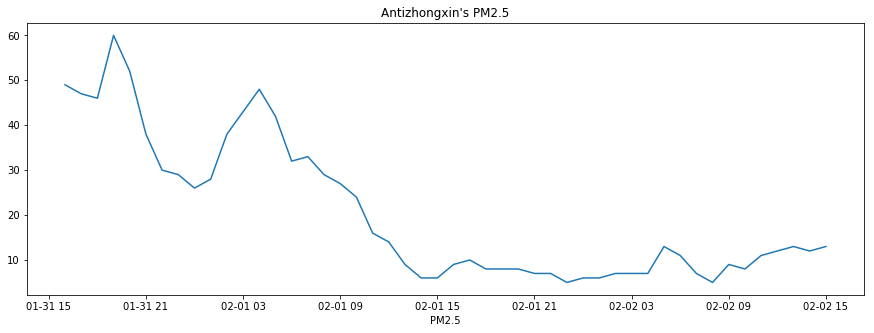

In [222]:
plt.figure(figsize=(15,5))
plt.plot(antizhongxin_pm2_5_48["utc_time"],antizhongxin_pm2_5_48["PM2.5"])
plt.xlabel("PM2.5")
plt.title("Antizhongxin's PM2.5")

In [226]:
model_integ1 = pf.ARIMA(data=antizhongxin_pm2_5, ar=12, integ=0, ma=12, target="PM2.5",family=pf.Normal())
x = model_integ1.fit("MLE")
x.summary()

Normal ARIMA(12,0,12)                                                                                     
======================================================= ==================================================
Dependent Variable: PM2.5                               Method: MLE                                       
Start Date: 12                                          Log Likelihood: -6102.1454                        
End Date: 1411                                          AIC: 12256.2908                                   
Number of observations: 1400                            BIC: 12392.6407                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 56.5464    0.0529     1068.974 0.0      (56.4428 | 56.6501)      
AR(1)                                

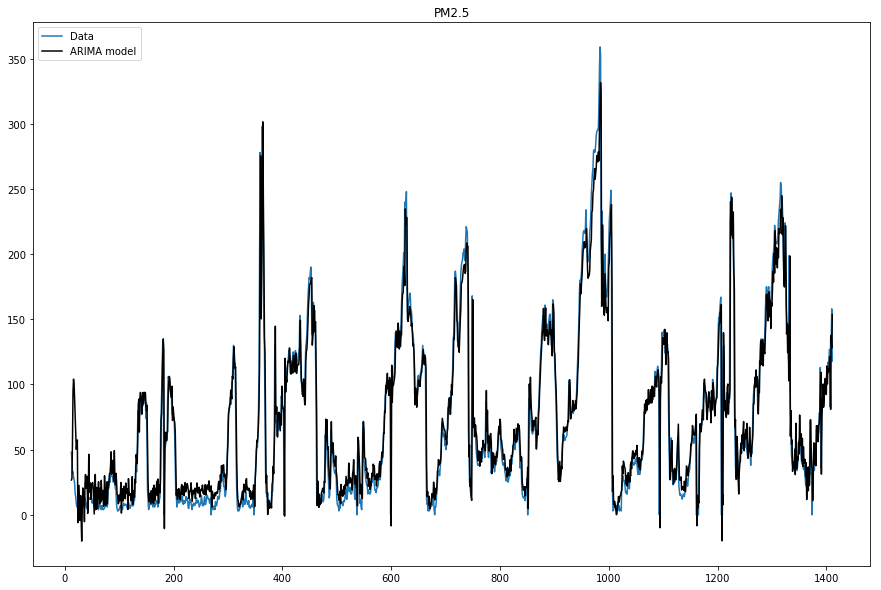

In [227]:
model_integ1.plot_fit(figsize=(15,10))

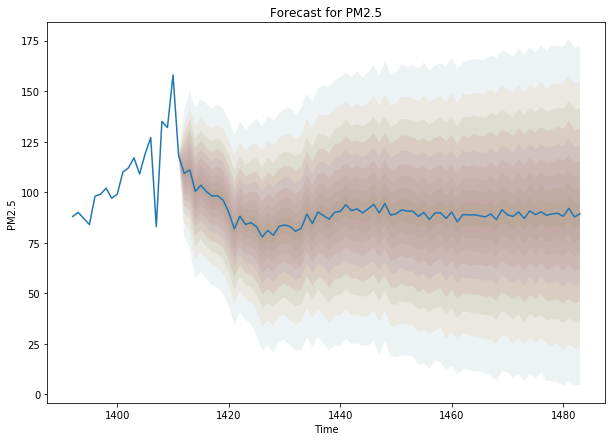

In [229]:
model_integ1.plot_predict(h=72)